In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import  DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

x_data = np.load('../data/metal.npy',allow_pickle = True)
c_data = np.load('../data/reaction.npy',allow_pickle = True)
sup_data = np.load('../data/support.npy',allow_pickle=True)


In [9]:
import os,sys
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)
from model_vae import CVAE

'c:\\Users\\User\\Desktop\\intern_practicing\\practice\\..'

## 데이터 train,val,test 6:2:2로 일단 unshuffle로 나누기

In [3]:
from model_vae import CVAE,cvae_loss_each,cvae_loss_optimized,cvae_loss

In [4]:
## train,test,validation_data 만들기
from sklearn.model_selection import train_test_split
x_train,x_test,c_train,c_test = train_test_split(x_data,c_data,test_size = 0.4,shuffle = False)
x_val,x_test,c_val,c_test = train_test_split(x_test,c_test,test_size = 0.5,shuffle= False)
print(x_train.shape,c_val.shape,x_test.shape) #0.6 #0.2 #0.2로 데이터 분류


(3544, 24) (1182, 9) (1182, 24)


# 데이터 scaler로 정리하기

In [5]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_c = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)
x_test_s = scaler_x.transform(x_test)
c_train_s = scaler_c.fit_transform(c_train)
c_val_s = scaler_c.transform(c_val)
c_test_s = scaler_c.transform(c_test)

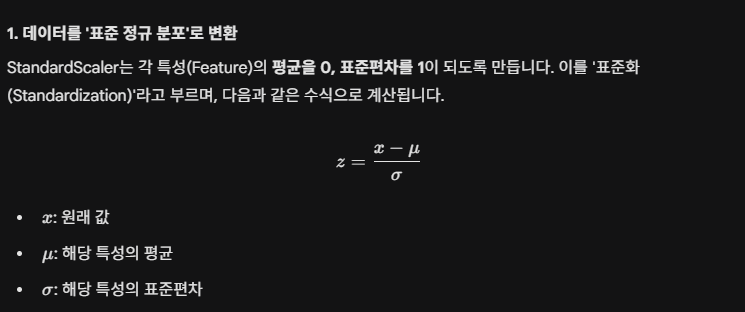

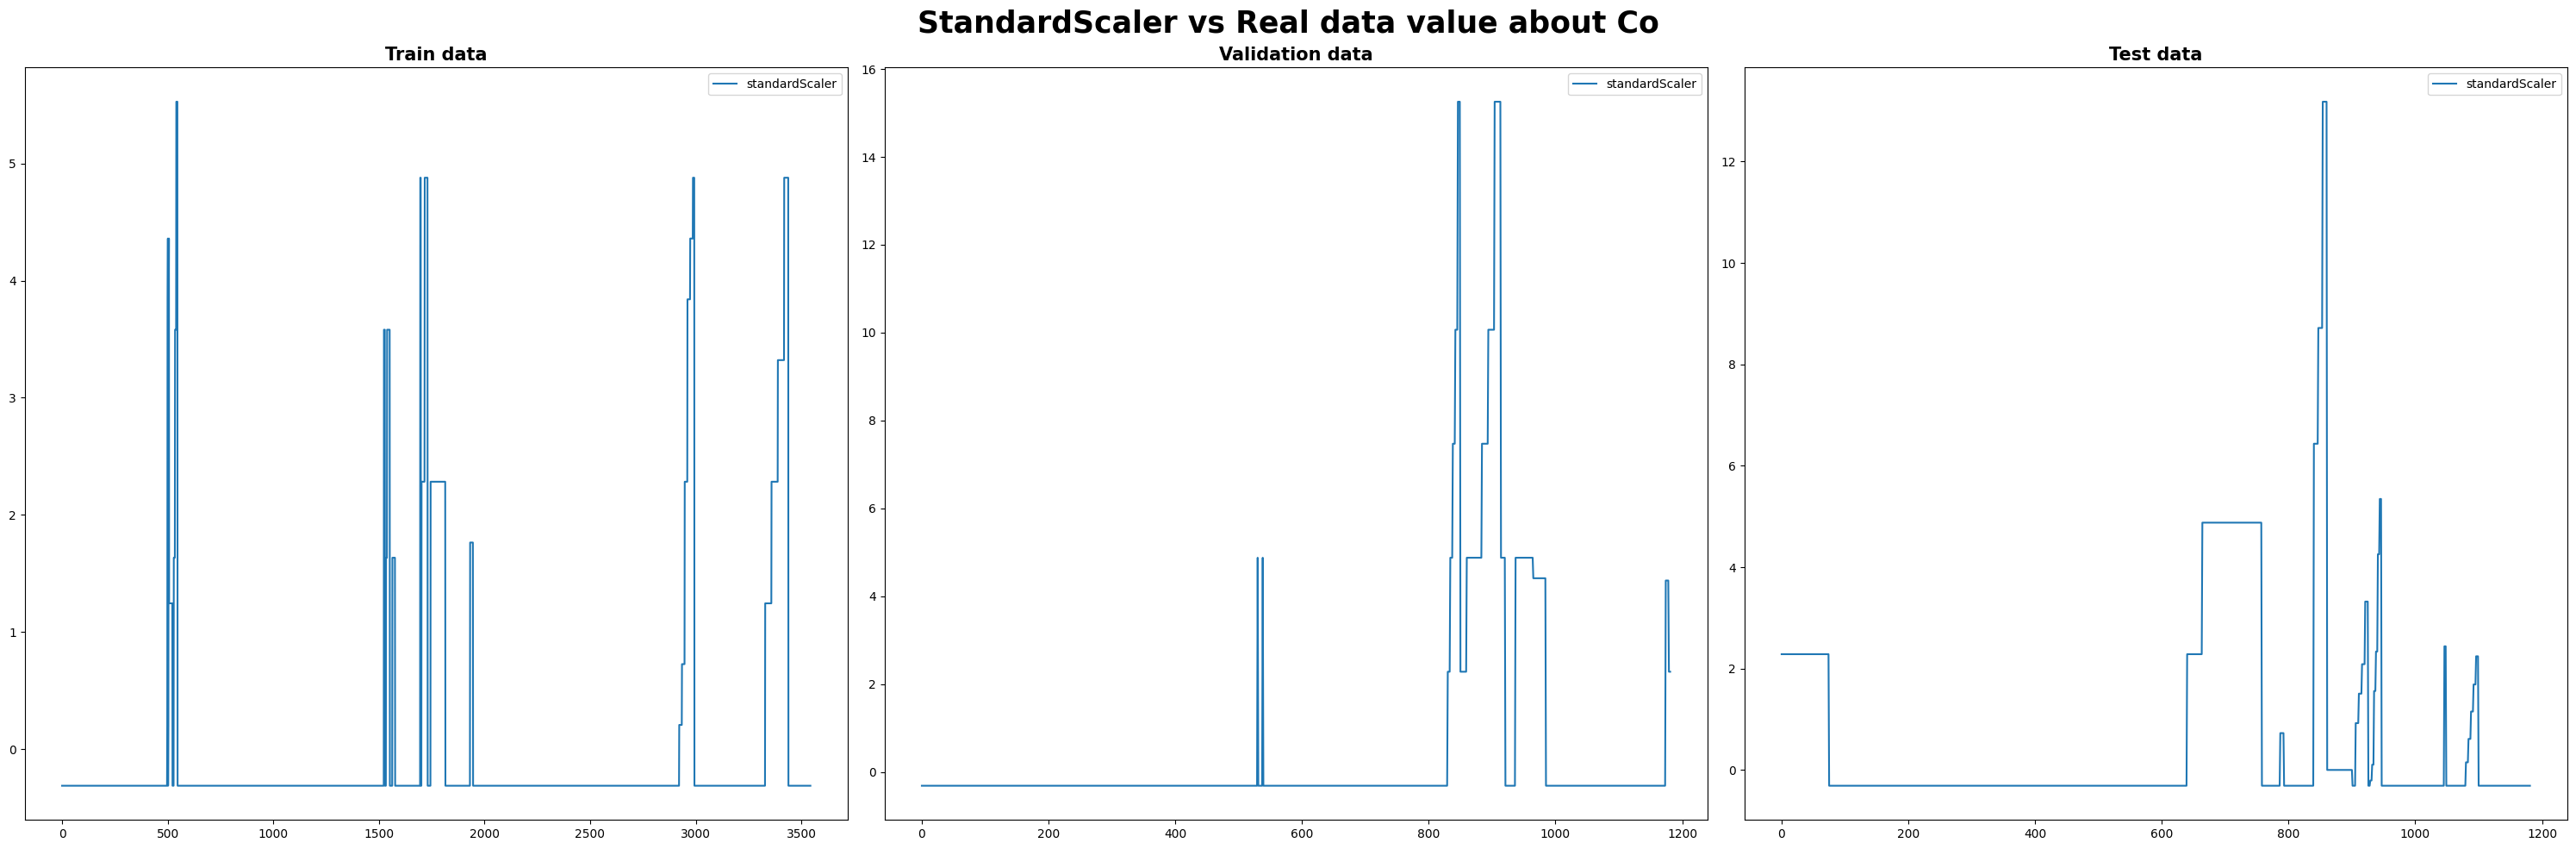

In [6]:
fig, axes = plt.subplots(1,3,figsize=(30,10))
x_datas = [x_train_s,x_val_s,x_test_s]
real_x_datas = [x_train,x_val,x_test]
names = ['Train', 'Validation', 'Test']
axes.flatten()
for i,x in enumerate(x_datas):
    ax = axes[i]
    ax.plot(x[:,1],label = 'standardScaler')
    # ax.plot(real_x_datas[i][:,1],label =' real')
    ax.legend()
    ax.set_title(f'{names[i]} data',fontsize = 15,fontweight = 'bold')
plt.suptitle('StandardScaler vs Real data value about Co',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.show()
    
    

## scaler데이터 numpy에서 tensor로 바꾸기

In [7]:
x_train_s = torch.tensor(x_train_s, dtype=torch.float32)
x_val_s   = torch.tensor(x_val_s,   dtype=torch.float32)
x_test_s  = torch.tensor(x_test_s,  dtype=torch.float32)

c_train_s = torch.tensor(c_train_s, dtype=torch.float32)
c_val_s   = torch.tensor(c_val_s,   dtype=torch.float32)
c_test_s  = torch.tensor(c_test_s,  dtype=torch.float32)

## 그냥 데이터 numpy에서 tensor로 바꾸기

In [8]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val   = torch.tensor(x_val,   dtype=torch.float32)
x_test  = torch.tensor(x_test,  dtype=torch.float32)

c_train = torch.tensor(c_train, dtype=torch.float32)
c_val   = torch.tensor(c_val,   dtype=torch.float32)
c_test  = torch.tensor(c_test,  dtype=torch.float32)

## model에 넣고 학습시키기

In [9]:
x_dim = x_train.shape[1]
c_dim = c_train.shape[1]

## cvae 모델에서 x_train, c_train
- case1:x_train,c_train
- case2:x_train_s,c_train_s

### case1:x_train,c_train(의미없는 결과들)

In [10]:
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim = 16)
x_hat,mu, logvar = model(x_train,c_train) # 그냥 x_train,c_train으로 학습시킨 값
# x_hat = x_hat.detach().cpu().numpy()
# x_hat = scaler_x.inverse_transform(x_hat)
# x_hat = torch.tensor(x_hat, dtype=torch.float32)
losses_1,recon_1,kls_1 = cvae_loss(x_hat,x_train,mu,logvar,beta = -0.01)
losses_1

tensor(nan, grad_fn=<AddBackward0>)

### case2:x_train_s,c_train_s

In [11]:
x_hat_not,mu, logvar = model(x_train,c_train) # 그냥 x_train_s,c_train_s로 학습시킨 값
losses_all,recon_all,kls_all = cvae_loss(x_hat,x_train_s,mu,logvar,beta = -0.01) 
losses_all

tensor(nan, grad_fn=<AddBackward0>)

### case2:x_train_s,c_train_s

In [12]:
x_hat,mu, logvar = model(x_train_s,c_train_s) # 그냥 x_train_s,c_train_s로 학습시킨 값
losses_2,recon_2,kls_2 = cvae_loss_optimized(x_hat,x_train_s,mu,logvar,beta = -0.01) 


In [13]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,1:25].columns
metal_columns

Index(['Perovskite', 'Co', 'Ba', 'Ca', 'Cu', 'Ce', 'Mn', 'La', 'Ni', 'Ag',
       'Pt', 'Mg', 'Ir', 'Au', 'K', 'Li', 'Ru', 'Rh', 'Fe', 'Pr', 'Pd', 'Sr',
       'Y', 'Zr'],
      dtype='object')

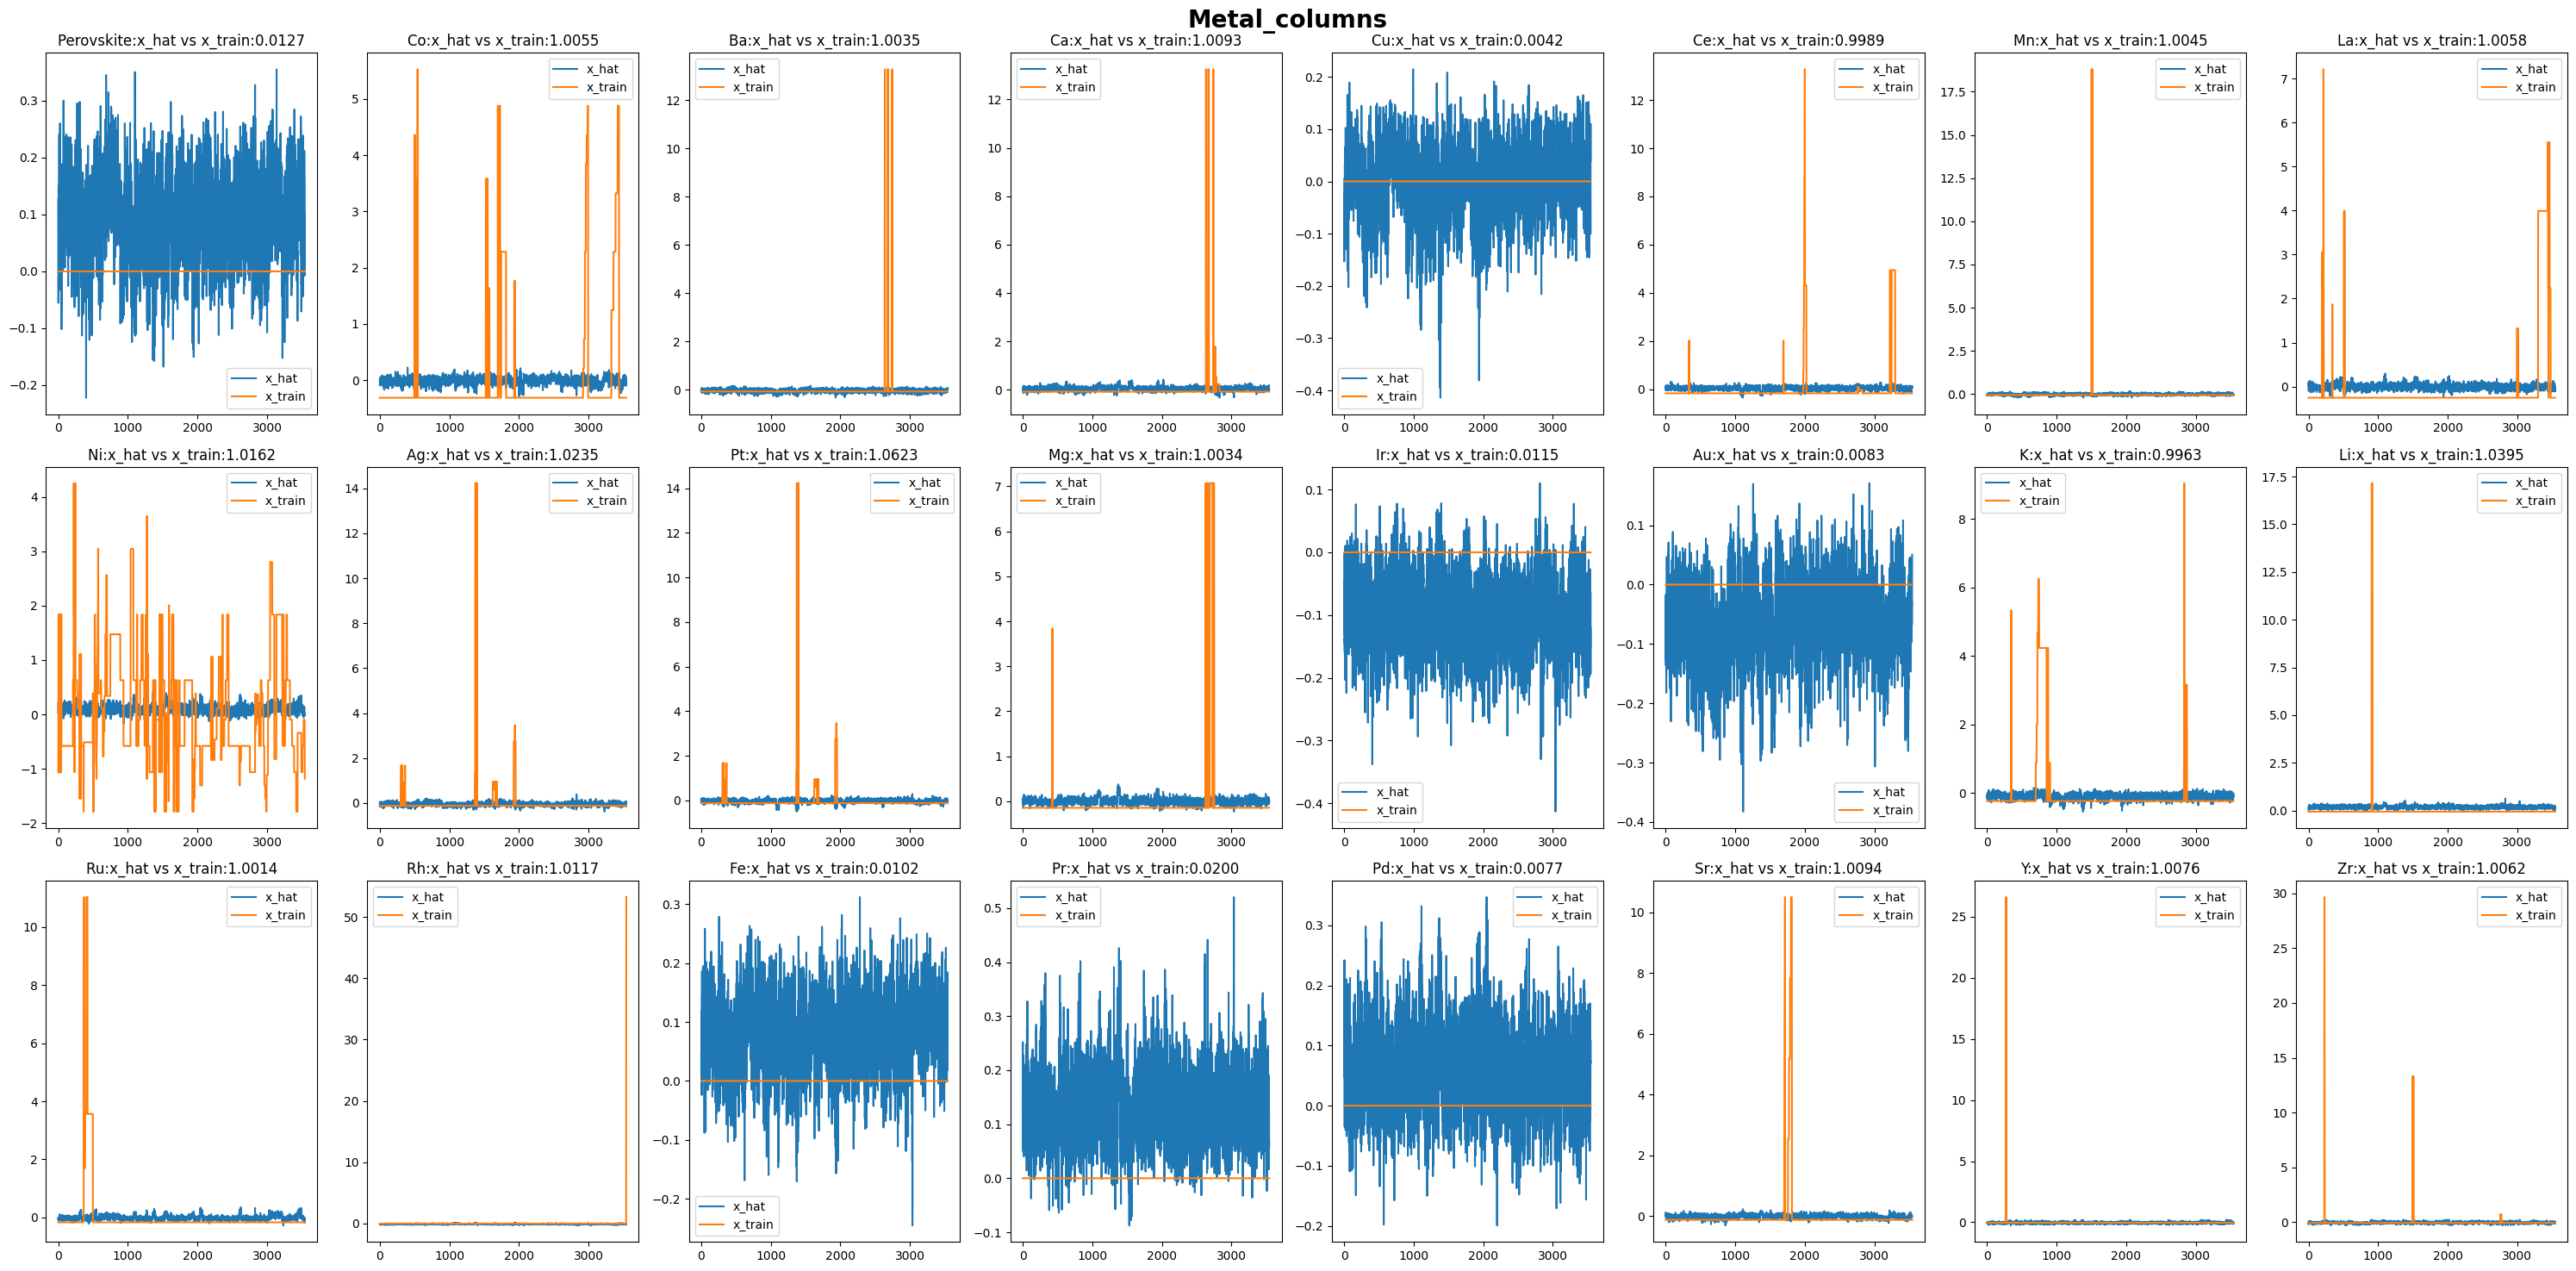

In [14]:
fig, axes = plt.subplots(x_hat[0].reshape(3,8).detach().cpu().numpy().shape[0],x_hat[1].reshape(3,8).detach().cpu().numpy().shape[1],figsize = (30,15))
axes = axes.flatten()
for i in range(x_hat[0].shape[0]):
    ax = axes[i]
    ax.plot(x_hat[:,i].detach().cpu().numpy(),label = 'x_hat')
    ax.plot(x_train_s[:,i],label = 'x_train')
    ax.set_title(f'{metal_columns[i]}:x_hat vs x_train:{losses_2[i]:.4f}')
    ax.legend()
plt.suptitle('Metal_columns',fontsize = 20,fontweight = 'bold')
plt.tight_layout()
plt.show()



## 다시 inverse해서 실제값들끼리의 비교 구하는 방식

In [15]:
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim = 16)
x_hat,mu, logvar = model(x_train_s,c_train_s)
x_hat = x_hat.detach().cpu().numpy()
x_hat = scaler_x.inverse_transform(x_hat)
x_hat = torch.tensor(x_hat, dtype=torch.float32)
value = cvae_loss(x_hat,x_train_s,mu,logvar,beta = -0.01)


In [16]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
learning_rate = 1e-3
z_dim = 16
epochs = 200
train_dataset = TensorDataset(x_train,c_train)
val_dataset = TensorDataset(x_val,c_val)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle = False)


## model에 cuda 연결하기

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

CVAE(
  (enc1): Linear(in_features=33, out_features=128, bias=True)
  (enc2): Linear(in_features=128, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=16, bias=True)
  (logvar): Linear(in_features=256, out_features=16, bias=True)
  (dec1): Linear(in_features=25, out_features=128, bias=True)
  (dec2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=24, bias=True)
)

In [18]:
# 모델의 구조에 대한 생각
from torchsummary import summary

summary(model, input_size=[(x_dim,), (c_dim,)], device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,352
            Linear-2                  [-1, 256]          33,024
            Linear-3                   [-1, 16]           4,112
            Linear-4                   [-1, 16]           4,112
            Linear-5                  [-1, 128]           3,328
            Linear-6                  [-1, 256]          33,024
            Linear-7                   [-1, 24]           6,168
Total params: 88,120
Trainable params: 88,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


# 어떤 parameter 형태로 구성되어있나 생각하기

In [19]:
model_para = list(model.parameters())
for i in range(2):
    print(f'{model_para[i]}')

Parameter containing:
tensor([[ 0.0418, -0.0903, -0.0479,  ...,  0.1651, -0.0425, -0.1433],
        [-0.0967,  0.0210, -0.0834,  ..., -0.0007,  0.0132, -0.0718],
        [-0.1522, -0.1333, -0.0624,  ...,  0.1476, -0.0323,  0.0849],
        ...,
        [-0.1329, -0.0345, -0.0810,  ..., -0.0616, -0.0442, -0.1100],
        [ 0.0648, -0.1215, -0.1571,  ..., -0.0969,  0.1104, -0.0345],
        [-0.1621, -0.1515, -0.0923,  ..., -0.0902,  0.1289, -0.0051]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0880, -0.0928,  0.1646, -0.0707, -0.1478, -0.0665,  0.0216, -0.0402,
         0.0165,  0.1279,  0.0351,  0.1057, -0.1664, -0.1668,  0.1057, -0.0478,
        -0.0346,  0.1487,  0.1583,  0.1230, -0.0777,  0.0230,  0.1687,  0.0472,
         0.0751,  0.1350, -0.1230,  0.0717, -0.0204,  0.0014, -0.0424,  0.1511,
         0.1600,  0.0033,  0.0675,  0.1189, -0.0229,  0.0525,  0.0414,  0.0406,
         0.0770,  0.0383, -0.0870,  0.0462, -0.0286,  0.0242, -0.0643, -0.0942

### weight, bias에 대한 parameters들을 나타낸다.
torch.Size([128, 33]) -> weight <br>
torch.Size([128]) -> bias

In [20]:
model_para = list(model.parameters())
for i in range(len(model_para)):
    print(f'{model_para[i].shape}')

torch.Size([128, 33])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([16, 256])
torch.Size([16])
torch.Size([128, 25])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([24, 256])
torch.Size([24])
